# Исследование рынка игровой индустрии

Исследование проведено для интернет-магазина компьютерных игр на основе открытых данных до 2016 года о продажах игр, оценках пользователей и экспертов, популярных жанрах и платформах. Цель исследования — выявить закономерности, определяющие успешность игры. Результаты исследования будут использоваться для прогнозирования популярности новых игр и планирования рекламных кампаний со ставкой на потенциально "звездные" релизы.

1. [Получение данных.](#step1)  
2. [Предобработка данных.](#step2)  
3. [Исследовательский анализ данных.](#step3) 
4. [Анализ пользователей каждого региона.](#step4) 
5. [Проверка гипотез.](#step5) 
6. [Общий вывод.](#step6) 

## Получение данных. <a id="step1"></a>    

### Импорт библиотек

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as st
import warnings
warnings.filterwarnings('ignore')

Прочитаем файл *games* и сохраним его в переменной *df*. 

In [2]:
df = pd.read_csv('/datasets/games.csv')

Получим первые 5 строк таблицы.

In [3]:
df.head()

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


Получим общую информацию о данных таблицы *df*.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
Name               16713 non-null object
Platform           16715 non-null object
Year_of_Release    16446 non-null float64
Genre              16713 non-null object
NA_sales           16715 non-null float64
EU_sales           16715 non-null float64
JP_sales           16715 non-null float64
Other_sales        16715 non-null float64
Critic_Score       8137 non-null float64
User_Score         10014 non-null object
Rating             9949 non-null object
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


Рассмотрим полученную информацию подробнее.

Всего в таблице 11 столбцов, тип данных - **float64**, **object**.

Подробно разберём, какие в *df* столбцы и какую информацию они содержат:

* Name — название игры;
* Platform — платформа;
* Year_of_Release — год выпуска;
* Genre — жанр игры;
* NA_sales — продажи в Северной Америке (миллионы проданных копий);
* EU_sales — продажи в Европе (миллионы проданных копий);
* JP_sales — продажи в Японии (миллионы проданных копий);
* Other_sales — продажи в других странах (миллионы проданных копий);
* Critic_Score — оценка критиков (максимум 100);
* User_Score — оценка пользователей (максимум 10);
* Rating — рейтинг от организации ESRB (англ. Entertainment Software Rating Board). Эта ассоциация определяет рейтинг компьютерных игр и присваивает им подходящую возрастную категорию.

Количество значений в столбцах различается. Это говорит о том, что в данных есть пустые значения.

### Вывод

Каждая строка таблицы содержит информацию об отдельной игре: название, платформа, год выпуска, жанр, продажи, оценка критиков и пользователей, рейтинг от ESRB. Проблемы, которые нужно решать - разный регистр названия столбцов и пропуски в столбцах: *Name*, *Year_of_Release*, *Genre*, *Critic_Score*, *User_Score*, *Rating*.

## Предобработка данных. <a id="step2"></a> 

Приведем названия столбцов к нижнему регистру.

In [5]:
df.columns = [col.lower() for col in df.columns]

### Обработка пропусков

Проверим данные на наличие пропусков вызовом набора методов для суммирования пропущенных значений.

In [6]:
df.isnull().sum()

name                  2
platform              0
year_of_release     269
genre                 2
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8578
user_score         6701
rating             6766
dtype: int64

Пустые значения свидетельствуют о том, что для некоторых игр доступна не вся информация. Причины могут быть разные: скажем, малоизвестные игры не имеют оценок критиков и пользователей, установленного рейтинга; год релиза пропущен из-за многократного его переноса.

Пустых значений в столбце *year_of_release* немного, удалим их.

In [7]:
df.dropna(subset=['year_of_release'], inplace=True)

Пропуски в столбцах *critic_score*, *user_score*, *rating* оставим без изменения. Замена этих значений на среднее, медиану может повлиять на результаты исследования.

Вызовем метод .value_counts(), который анализирует столбец, выбирает каждое уникальное значение и подсчитывает частоту его встречаемости в списке. Применим метод к столбцу *user_score*.

In [8]:
df['user_score'].value_counts()

tbd    2376
7.8     322
8       285
8.2     276
8.3     252
       ... 
1.1       2
0.9       2
2.3       2
9.7       1
0         1
Name: user_score, Length: 96, dtype: int64

В столбце c оценками пользователей содержится аббревиатура 'tbd' ('подлежит уточнению'). Из-за наличия строковых значений в столбце некоторые операции с данными будут невозможны. Превратим эти значения в числовой тип float64 (вещественное число).

### Замена типа данных

Заменим вещественный тип данных в столбце *year_of_release* на целочисленный методом .astype() c аргументом ('int'). 

In [9]:
df['year_of_release'] = df['year_of_release'].astype('int')

Заменим строковые значения в столбце *user_score* на тип float64 методом to_numeric().

In [10]:
df['user_score'] = pd.to_numeric(df['user_score'], errors='coerce') 

### Добавление новых параметров

Посчитаем суммарные продажи во всех регионах и запишем их в отдельный столбец.

In [11]:
df['all_sales'] = df['na_sales'] + df['eu_sales'] + df['jp_sales'] + df['other_sales']

In [12]:
df.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,all_sales
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E,82.54
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN,40.24
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E,35.52
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.0,8.0,E,32.77
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN,31.38


### Вывод

На этапе предобработки данных обнаружились пропуски, которые было решено оставить без изменения, так как подходящего значения на замену не нашлось и обработка этих значений может повлиять на результаты исследования. Строки с пропусками в столбце *year_of_release* были удалены, так как их немного. Также мы изменили тип данных, где это было нужно и добавили в таблицу новые параметры. 

## Исследовательский анализ данных. <a id="step3"></a> 

Посмотрим, сколько игр выпускалось в разные годы.

Text(0.5, 1.0, 'Распределение количества игр по годам')

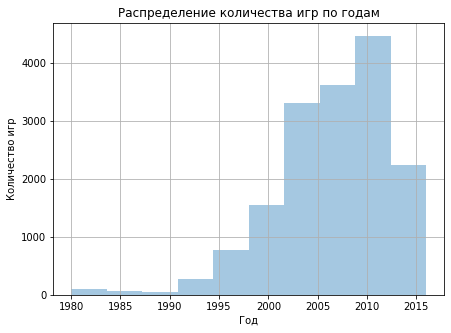

In [13]:
df['year_of_release'].hist(grid=True, figsize=(7,5), alpha=0.4)
plt.ylabel('Количество игр')
plt.xlabel('Год')
plt.title('Распределение количества игр по годам')

"Скачек" в выпуске игр произошел в 2000-х. Для нашего исследования возьмем срез данных по дате релиза начиная с 2000 года.

In [14]:
df_after_2000 = df.query('year_of_release >= 2000')

Посмотрим, как менялись продажи по платформам. Выберим платформы с наибольшими суммарными продажами. 

In [15]:
top_platforms = df_after_2000.groupby('platform')['all_sales'].sum().sort_values(ascending = False).reset_index()

top_platforms.head()

,platform,all_sales
0,PS2,1233.56
1,X360,961.24
2,PS3,931.34
3,Wii,891.18
4,DS,802.76


Платформы с наибольшими суммарными продажами - PS2, X360, PS3. Построим по этим платформам распределение суммарных продаж по годам.

In [16]:
top_platforms_list = ['PS2', 'X360', 'PS3']

In [17]:
df_top = df_after_2000.query('platform == @top_platforms_list').reset_index(drop=True)

In [18]:
df_top_pivot = df_top.pivot_table(index='year_of_release', columns='platform', values='all_sales', aggfunc='sum').reset_index()

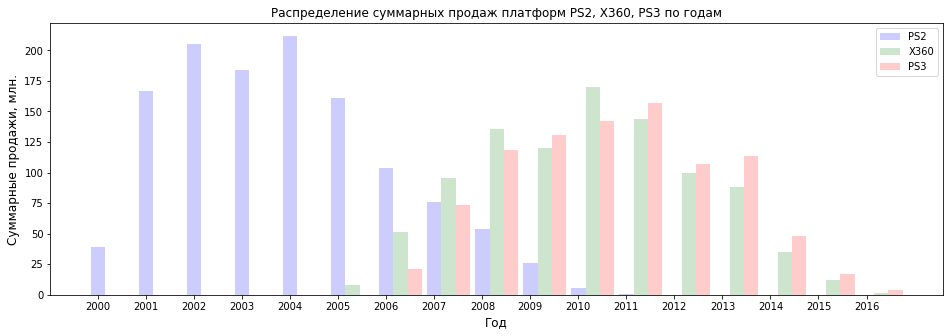

In [19]:
fig, (ax1) = plt.subplots(nrows=1, ncols=1, figsize=(16, 5))

ax1.set_ylabel('Суммарные продажи, млн.', fontsize=12)
ax1.set_xlabel('Год', fontsize=12)

year_index = np.arange(df_top_pivot['year_of_release'].min(), df_top_pivot['year_of_release'].max()+1)
width = 0.3
plt.bar(df_top_pivot['year_of_release'], df_top_pivot['PS2'], width, alpha=0.2, color = "b", label="PS2")
plt.bar(df_top_pivot['year_of_release']+ width, df_top_pivot['X360'], width, alpha=0.2, color = "g", label="X360")
plt.bar(df_top_pivot['year_of_release']+ width+width, df_top_pivot['PS3'], width, alpha=0.2, color = "r", label="PS3")
plt.xticks(year_index)
plt.legend()
plt.title('Распределение суммарных продаж платформ PS2, X360, PS3 по годам')
plt.show()

По графику видно, что "период жизни" игровой платформы - в районе 10 лет. За этот срок суммарные продажи по ней достигают максимума и опускаются до минимума.

Для прогноза на 2017 год возьмем актуальный срез данных - начиная с 2013 года. Так мы сможем выбрать платформы, которые растут и лидируют по продажам, а так же не брать в расчет платформы с истекающим "сроком жизни".

In [20]:
df_actual = df.query('year_of_release >= 2013').reset_index(drop=True)
df_actual_pivot = df_actual.pivot_table(index='year_of_release', columns='platform',\
                                        values='all_sales', aggfunc='sum').reset_index()
df_actual_pivot.head()

platform,year_of_release,3DS,DS,PC,PS3,PS4,PSP,PSV,Wii,WiiU,X360,XOne
0,2013,56.57,1.54,12.38,113.25,25.99,3.14,10.59,8.59,21.65,88.58,18.96
1,2014,43.76,NaN,13.28,47.76,100.00,0.24,11.90,3.75,22.03,34.74,54.07
2,2015,27.78,NaN,8.52,16.82,118.90,0.12,6.25,1.14,16.35,11.96,60.14
3,2016,15.14,NaN,5.25,3.60,69.25,NaN,4.25,0.18,4.60,1.52,26.15


По таблице видно, что подходящие платформы - PS4, XOne. Сделаем срез данных по этим платформам. 

In [21]:
top_platforms_actual_list = ['PS4', 'XOne']
df_top_actual = df_actual.query('platform == @top_platforms_actual_list').reset_index(drop=True)

Построим график «ящик с усами» по глобальным продажам игр в разбивке по платформам. Опишем результат.

Text(0, 0.5, 'Суммарные продажи, млн.')

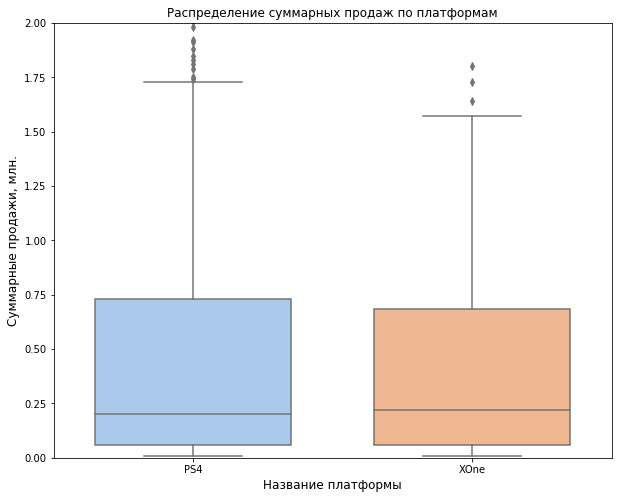

In [22]:
ax = plt.subplots(figsize=(10, 8))
ax = sns.boxplot(x="platform", y="all_sales", data=df_top_actual, palette='pastel', width=0.7)
ax.set(ylim=(0, 2))
ax.set_title('Распределение суммарных продаж по платформам', fontsize=12)
ax.set_xlabel('Название платформы', fontsize=12)
ax.set_ylabel('Суммарные продажи, млн.', fontsize=12)

Оба графика скошены вправо (то есть в сторону положительного направления оси с учётом ориентации именно этого изображения — вверх). Расстояние между первым квартилем и медианой заметно меньше, чем расстояние между медианой и третьим квартилем. Распределение нессиметрично с длинным правым хвостом. У основной части игр, выпущенных на платформах PS4 и XOne количество продаж ощутимо превышает медиану. Медиана продаж XOne чуть больше, чем медиана продаж PS4, но по количеству продаж максимальное значение у платформы PS4. Точками на графике обозначаются выбросы — те значения, которые не вписываются в промежуток значений, заданный усами графика.

Посмотрим, как влияют на продажи внутри платформы отзывы пользователей и критиков. Построим диаграмму рассеяния и посчитаем корреляцию между отзывами и продажами.

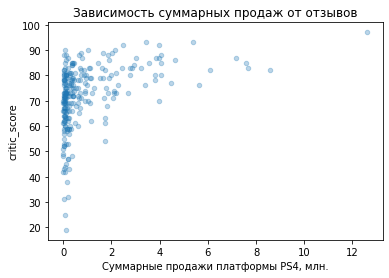

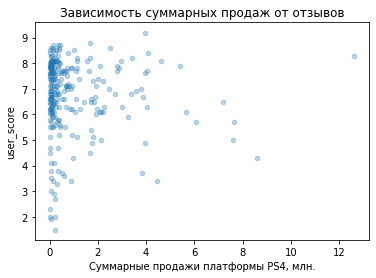

In [23]:
df_ps4 = df_top_actual.query('platform == "PS4"').reset_index(drop=True)

y_columns = ['critic_score', 'user_score']
for y in y_columns:
    df_ps4.plot(x='all_sales', y=y, kind='scatter', alpha=0.3, title='Зависимость суммарных продаж от отзывов')
    plt.xlabel('Суммарные продажи платформы PS4, млн.')

In [24]:
print(df_ps4['critic_score'].corr(df_ps4['all_sales']))
print(df_ps4['user_score'].corr(df_ps4['all_sales']))

0.40656790206178095
-0.031957110204556424


По графикам видно, что взаимосвязь между оценками пользователей, критиков и продажами игр на платформе PS4 слабая. Корреляция в 0,41 между оценками критиков и продажами говорит о наличии связи, однако не слишком сильной. Корреляция в 0,03 говорит о том, что связь между оценками ползователей и продажами слабая, либо отсутсвует вовсе, либо у связи более сложный, не линейный характер.

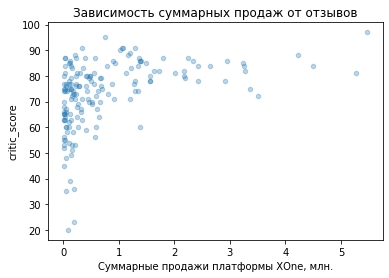

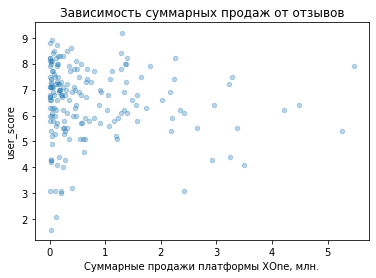

In [25]:
df_xone = df_top_actual.query('platform == "XOne"').reset_index(drop=True)

y_columns = ['critic_score', 'user_score']
for y in y_columns:
    df_xone.plot(x='all_sales', y=y, kind='scatter', alpha=0.3, title='Зависимость суммарных продаж от отзывов')
    plt.xlabel('Суммарные продажи платформы XOne, млн.')

In [26]:
print(df_xone['critic_score'].corr(df_xone['all_sales']))
print(df_xone['user_score'].corr(df_xone['all_sales']))

0.4169983280084017
-0.06892505328279414


По графикам видно, что взаимосвязь между оценками пользователей, критиков и продажами игр на платформе XOne слабая. Корреляция в 0,42 между оценками критиков и продажами говорит о наличии связи, однако не слишком сильной. Корреляция в 0,07 говорит о том, что связь между оценками ползователей и продажами слабая, либо отсутсвует вовсе, либо у связи более сложный, не линейный характер.

На продажи игр на платформах PS4, XOne не влияют отзывы пользователей и критиков.

Посмотрим на общее распределение игр по жанрам. 

Text(0, 0.5, 'Суммарные продажи, млн.')

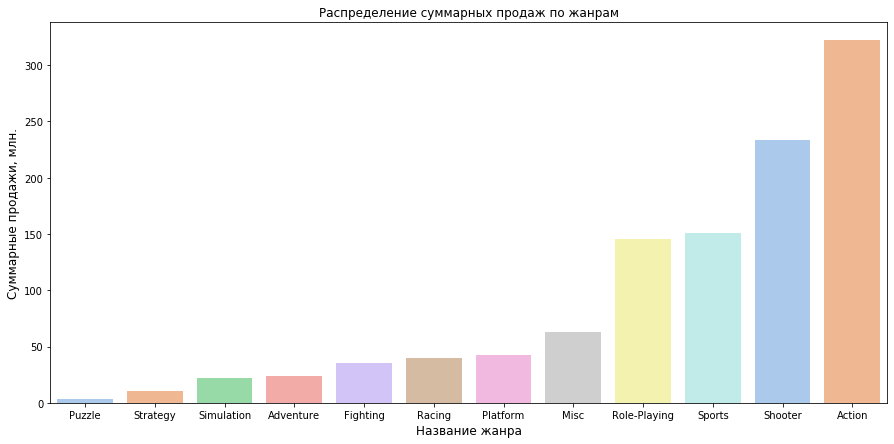

In [27]:
genre_pivot = df_actual.pivot_table(index='genre', values='all_sales', aggfunc = {'sum'}).sort_values(by='sum')
f = plt.subplots(figsize=(15,7))
f = sns.barplot(x=genre_pivot.index, y='sum', data=genre_pivot, palette='pastel')
f.set_title('Распределение суммарных продаж по жанрам', fontsize=12)
f.set_xlabel('Название жанра', fontsize=12)
f.set_ylabel('Суммарные продажи, млн.', fontsize=12)

Жанры с самыми низкими продажами: Puzzle, Strategy, Simulation, Adventure. Наиболее продаваемые жанры: Action, Shooter,  Sports, Role-Playing.

### Вывод

Успешность игры (ее продажы) не зависит от оценок пользователей и критиков, но зависит от жанра. Самые продаваемые игры с жанрами: Action, Shooter,  Sports, Role-Playing. Потенциально популярные платформы на 2017 год - PS4, XOne.

## Анализ пользователей каждого региона. <a id="step4"></a> 

Составим портрет пользователя каждого региона.

1. Определим для пользователя каждого региона (NA, EU, JP) самые популярные платформы (топ-5).

In [28]:
df_platform_na_sales = df_actual.pivot_table(index='platform', values=['na_sales'], aggfunc='sum')\
.sort_values(by='na_sales', ascending = False)
df_platform_na_sales.head()

,na_sales
platform,
PS4,108.74
XOne,93.12
X360,81.66
PS3,63.50
3DS,38.20


**Топ-5 платформ для пользователей в Северной Америке**: PS4, XOne, X360, PS3, 3DS.

In [29]:
df_platform_eu_sales = df_actual.pivot_table(index='platform', values=['eu_sales'], aggfunc='sum')\
.sort_values(by='eu_sales', ascending = False)
df_platform_eu_sales.head()

,eu_sales
platform,
PS4,141.09
PS3,67.81
XOne,51.59
X360,42.52
3DS,30.96


**Топ-5 платформ для пользователей в Европе**: PS4, PS3, XOne, X360, 3DS. В отличии от пользователей из Европы в Северной Америке на втором месте XOne, а PS3 только на четвертом. По всем платформам объем продаж в Северной Америке больше, кроме лидирующей платформы PS4 - в Европе продано на 32,35 млн больше.

In [30]:
df_platform_jp_sales = df_actual.pivot_table(index='platform', values=['jp_sales'], aggfunc='sum')\
.sort_values(by='jp_sales', ascending = False)
df_platform_jp_sales.head()

,jp_sales
platform,
3DS,67.81
PS3,23.35
PSV,18.59
PS4,15.96
WiiU,10.88


**Топ-5 платформ для пользователей из Японии**: 3DS, PS3, PSV, PS4, WiiU. В Японии в лидерах платформа 3DS, которая в других регионах на 5 месте по продажам. Также в топ входят платформы, которых нет в топ-5 Северной Америки и Европы - это PSV и WiiU. Популярные в Северной Америке и Европе платформы XOne, X360 не вошли в топ-5 в Японии.

2. Определим для пользователя каждого региона (NA, EU, JP) самые популярные жанры (топ-5).

In [31]:
df_genre_na_sales = df_actual.pivot_table(index='genre', values=['na_sales'], aggfunc='sum')\
.sort_values(by='na_sales', ascending = False)
df_genre_na_sales.head()

,na_sales
genre,
Action,126.05
Shooter,109.74
Sports,65.27
Role-Playing,46.40
Misc,27.49


**Топ-5 жанров для пользователей из Северной Америки**: Action, Shooter, Sports, Role-Playing, Misc.

In [32]:
df_genre_eu_sales = df_actual.pivot_table(index='genre', values=['eu_sales'], aggfunc='sum')\
.sort_values(by='eu_sales', ascending = False)
df_genre_eu_sales.head(6)

,eu_sales
genre,
Action,118.13
Shooter,87.86
Sports,60.52
Role-Playing,36.97
Racing,20.19
Misc,20.04


**Топ-5 жанров для пользователей из Европы**: Action, Shooter, Sports, Role-Playing, Racing. Топ практически аналогичен топ-5 жанров для Северной Америки, за исключением послелнего места: жанр Misc потеснил жанр Racing, но Misc не сильно остает по продажам и находится на 6 месте.

In [33]:
df_genre_jp_sales = df_actual.pivot_table(index='genre', values=['jp_sales'], aggfunc='sum')\
.sort_values(by='jp_sales', ascending = False)
df_genre_jp_sales.head()

,jp_sales
genre,
Role-Playing,51.04
Action,40.49
Misc,9.20
Fighting,7.65
Shooter,6.61


**Топ-5 жанров для пользователей из Японии**: Role-Playing, Action, Misc, Fighting, Shooter. В топ входят жанры, которые отсутвуют в топах Северной Америки и Европы, это - Fighting, Shooter. Лидирующую позицию занимает жанр Role-Playing, который в других регионах находится на 4 месте.

3. Посмотрим, как влияет рейтинг ESRB на продажи по регионам.

Text(0, 0.5, 'Продажи, млн.')

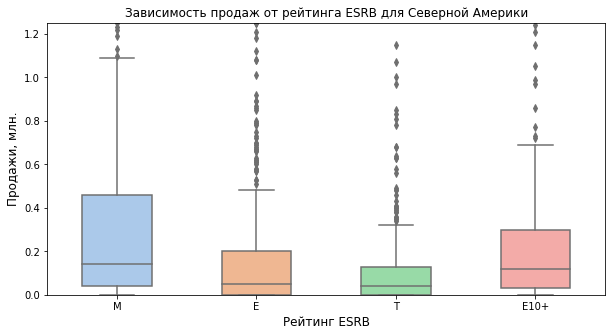

In [34]:
ax = plt.subplots(figsize=(10, 5))
ax=sns.boxplot(y="na_sales", x="rating", data=df_actual, palette='pastel', width=0.5)
ax.set(ylim=(0, 1.25))
ax.set_title('Зависимость продаж от рейтинга ESRB для Северной Америки', fontsize=12)
ax.set_xlabel('Рейтинг ESRB', fontsize=12)
ax.set_ylabel('Продажи, млн.', fontsize=12)

Text(0, 0.5, 'Продажи, млн.')

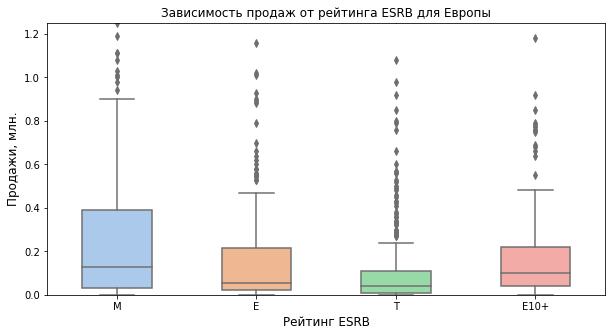

In [35]:
ax = plt.subplots(figsize=(10, 5))
ax=sns.boxplot(y="eu_sales", x="rating", data=df_actual, palette='pastel', width=0.5)
ax.set(ylim=(0, 1.25))
ax.set_title('Зависимость продаж от рейтинга ESRB для Европы', fontsize=12)
ax.set_xlabel('Рейтинг ESRB', fontsize=12)
ax.set_ylabel('Продажи, млн.', fontsize=12)

Text(0, 0.5, 'Продажи, млн.')

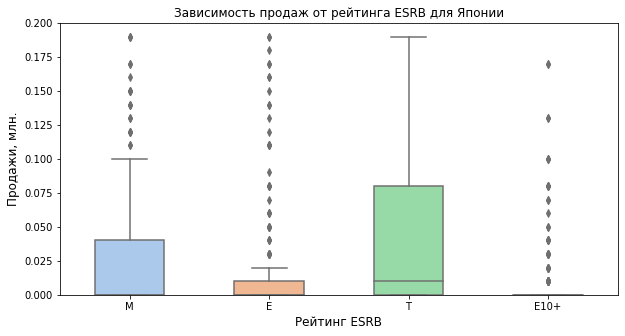

In [36]:
ax = plt.subplots(figsize=(10, 5))
ax=sns.boxplot(y="jp_sales", x="rating", data=df_actual, palette='pastel', width=0.5)
ax.set(ylim=(0, 0.2))
ax.set_title('Зависимость продаж от рейтинга ESRB для Японии', fontsize=12)
ax.set_xlabel('Рейтинг ESRB', fontsize=12)
ax.set_ylabel('Продажи, млн.', fontsize=12)

Как видно из графиков, ситуация в Северной Америке и Европе похожа: больше всего игр продают с рейтингом М. В Японии же уверенно лидируют игры с рейтингом Т и практически не продаются игры с рейтингом Е10+.

### Вывод

Успешность платформ и игр зависит от региона продаж.

Пользователи в Северной Америке и Европе похожи по своим предпочтениям, в топ входят одинаковые платформы (PS4, XOne, X360, PS3, 3DS) и жанры (Action, Shooter, Sports, Role-Playing, Racing, Misc). Мы видим в этих списках платформы и жанры, которые мы определили, как перспективные на 2017 год: платформы - PS4, XOne, жанры - Action, Sports, Shooter, Role-Playing.

Рынок игр в Японии по объему продаж меньше, чем североамериканский и европейский и обладает своими особенностями. В топ-5 входят следующие платформы: 3DS, PS3, PSV, PS4, WiiU. В топ-5 жанров входят Role-Playing, Action, Misc, Fighting, Shooter. Как видно, в пятерку входят платформы и жанры, которые не встречаются в топ-5 в Северной Америке и Европе и лидирующие места занимают платформа 3DS и жанр Role-Playing.

В Японии больше всего продаж игр с рейтингом Т, в Северной Америке и Европе - с рейтингом М (при этом игр с рейтингом Т продается меньше всего).

## Проверка гипотез. <a id="step5"></a> 

1. Проверим гипотезу: средние пользовательские рейтинги платформ Xbox One и PC одинаковые.

Сформулируем нулевую гипотезу H₀: средний пользовательский рейтинг платформы Xbox One равен среднему пользовательскому рейтингу платформы РС. Сформулируем альтернативную гипотезу H₁: средний пользовательский рейтинг платформы Xbox One не равен среднему пользовательскому рейтингу платформы РС.

In [37]:
df.dropna(subset=['user_score'], inplace=True)

In [38]:
df_xbox_one = df.query('platform == "XOne"').reset_index(drop=True)
df_pc = df.query('platform == "PC"').reset_index(drop=True)

Сравним дисперсии выборок для корректного определения атрибута `equal_val` в Т–тесте.

In [39]:
variance_xbox = np.var(df_xbox_one['user_score'], ddof=1)
print('Дисперсия выборки для платформы Xbox One:', variance_xbox)

Дисперсия выборки для платформы Xbox One: 1.9069968429360695


In [40]:
variance_pc = np.var(df_pc['user_score'], ddof=1)
print('Дисперсия выборки для платформы РС:', variance_pc)

Дисперсия выборки для платформы РС: 2.349224375076853


Дисперсии различаются более чем на 5%, считаем отличие значимым и выбираем `equal_var = False`.

In [41]:
print(df_xbox_one['user_score'].mean())
print(df_pc['user_score'].mean())

6.521428571428572
7.065960264900661


In [42]:
alpha = 0.05

results = st.ttest_ind(
    df_xbox_one['user_score'], 
    df_pc['user_score'], equal_var = False)

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу.')
else:
    print('Не получилось отвергнуть нулевую гипотезу.') 

p-значение: 4.5385802963771776e-06
Отвергаем нулевую гипотезу.


2. Проверим гипотезу: cредний пользовательский рейтинг жанра Action (англ. «действие», экшен-игры) равен cреднему пользовательскому рейтингу жанра Sports (англ. «спортивные соревнования»).

Сформулируем нулевую гипотезу H₀: cредний пользовательский рейтинг жанра Action равен cреднему пользовательскому рейтингу жанра Sports. Сформулируем альтернативную гипотезу H₁: cредний пользовательский рейтинг жанра Action не равен cреднему пользовательскому рейтингу жанра Sports.

In [43]:
df_action = df.query('genre == "Action"').reset_index(drop=True)
df_spots = df.query('genre == "Sports"').reset_index(drop=True)

Сравним дисперсии выборок для корректного определения атрибута `equal_val` в Т–тесте.

In [44]:
variance_action = np.var(df_action['user_score'], ddof=1)
print('Дисперсия выборки для жанра Action:', variance_action)

Дисперсия выборки для жанра Action: 2.027493768262496


In [45]:
variance_spots = np.var(df_spots['user_score'], ddof=1)
print('Дисперсия выборки для жанра Action:', variance_spots)

Дисперсия выборки для жанра Action: 2.623055812519272


Дисперсии различаются более чем на 5%, считаем отличие значимым и выбираем `equal_var = False`.

In [46]:
print(df_action['user_score'].mean())
print(df_spots['user_score'].mean())

7.058129175946549
6.951433857539316


In [47]:
alpha = 0.05

results = st.ttest_ind(
    df_action['user_score'], 
    df_spots['user_score'], equal_var = False)

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу.')
else:
    print('Не получилось отвергнуть нулевую гипотезу.') 

p-значение: 0.07370217419278534
Не получилось отвергнуть нулевую гипотезу.


### Вывод

Данные противоречат гипотезе "средний пользовательский рейтинг платформы Xbox One равен среднему пользовательскому рейтингу платформы РС", мы отвергаем эту гипотезу. Данные не противоречат гипотезе "cредний пользовательский рейтинг жанра Action равен cреднему пользовательскому рейтингу жанра Sports", мы не отвергаем эту гипотезу. 

## Шаг 6. Общий вывод. <a id="step6"></a> 

**Цель исследования** — выявить закономерности, определяющие успешность игры, для прогнозирования популярности новых игр и планирования рекламных кампаний со ставкой на потенциально "звездные" релизы.

В ходе исследования был выявлен средний цикл жизни игровой платформы на рынке — 10 лет, при этому **пик популярности платформа достигает на 3-5 год существования**, а после появляются новые, более технологичные платформы или готовятся к релизу новые версии старых платформ. Это означает, что **для прогнозов необходимо учитывать "жизненный цикл"** платформы, отдавая приоритет более молодым версиям (3-5 лет на рынке) **и следить за анонсами выхода новых версий популярных на текущий момент платформ** (так как есть тенденция "преемственности" — с выходом новой версии платформы, старая начинает терять популярность, а новая быстрее завоевывает аудиторию).

Для построения прогнозов подходят данные за последние 2-3 года: для нашего исследования был взят период с 2013 по 2016 года.

В ходе исследования мы выявили **закономерности, от которых не зависит успех** (объем продаж) игр:
- оценки пользователей (корреляция 0,03 между оценками пользователей и продажами на платформе PS4 и корреляция 0,07 между теми же показателями на платформе XOne говорит о том, что эти показатели связаны слабо, либо не связаны между собой и хорошие/плохие оценки пользователей не могут повлиять на продажи игр);
- оценки критиков (корреляция в 0,41 между оценками критиков и продажами на платформе PS4 и корреляция в 0,42 между теми же показателями на платформе XOne говорит о наличии связи, однако не слишком сильной и не влияющей на объем продаж). 

**Закономерности, от которых завист успех** (объем продаж) игр:
- жанр игры (в ходе исследования мы определили, что игры с жанрами Action, Shooter, Sports, Role-Playing лидируют по продажам, а игры с жанрами Puzzle, Strategy, Simulation, Adventure находятся на дне продаж);
- регион продаж (продажи зависят от предпочтений пользователей в регионах);
- рейтинг ESRB.

При подготовке рекламной кампании нужно учитывать, что перспективные платформы на 2017 год -  PS4, XOne. Также нужно принять во внимание различия в предпочтениях пользователей по регионам. В Северной Америки и Европе популярны игры с жанрами Action, Shooter, Sports, Role-Playing, Racing, Misc, пользователи из Японии предпочитают игры с жанрами Role-Playing, Action, Misc, Fighting, Shooter. В Японии уверенно лидируют игры с рейтингом Т и практически не продаются игры с рейтингом Е10+, в Северной Америке и Европе лидер - игры с рейтингом М, при этом игр с рейтингом Т продается меньше всего.